In [1]:
import numpy as np
import pandas as pd
import warnings # Supress warnings
from IPython.display import display # SHAP Plots for coloring

column_names = ['acc_status', 'duration_months', 'credit_history', 'purpose', 'credit_amount', 'savings', 'present_employment', 'installment_rate',
                'personal_sex_status', 'guarantors', 'present_residence', 'properties', 'age', 'other_installment_plans', 'housing', 'n_credits',
                'job_status', 'liable_support', 'telephone', 'foreign', 'risk']
df = pd.read_csv('../data/german.data', names = column_names, delimiter=' ') 
df.head(2)


acc_status  duration_months credit_history purpose  credit_amount savings  \
0        A11                6            A34     A43           1169     A65   
1        A12               48            A32     A43           5951     A61   

  present_employment  installment_rate personal_sex_status guarantors  ...  \
0                A75                 4                 A93       A101  ...   
1                A73                 2                 A92       A101  ...   

   properties age  other_installment_plans housing n_credits  job_status  \
0        A121  67                     A143    A152         2        A173   
1        A121  22                     A143    A152         1        A173   

  liable_support  telephone foreign risk  
0              1       A192    A201    1  
1              1       A191    A201    2  

[2 rows x 21 columns]

The prevalent class is 1 with a 70% (good) of the data. For that type of class we want to get almost all bad risk, which in other words,
would be the FN, increase recall, after the mapping increase the assertments of 1 instead of 0.

In [2]:
df['risk'].value_counts() # It requires to add balance_accuracy as one of the scorers

risk
1    700
2    300
Name: count, dtype: int64

In [3]:
df.isnull().sum() # No null cells

acc_status                 0
duration_months            0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
present_employment         0
installment_rate           0
personal_sex_status        0
guarantors                 0
present_residence          0
properties                 0
age                        0
other_installment_plans    0
housing                    0
n_credits                  0
job_status                 0
liable_support             0
telephone                  0
foreign                    0
risk                       0
dtype: int64

#### Preprocessing: Encoding and Binary Target

In [4]:
from category_encoders import TargetEncoder
from constants import CATEGORICAL_COLUMNS

def preprocessing(X_train, y_train):
    encoder_target = TargetEncoder()
    y_train_num = y_train.map({2: 1, 1: 0}) # More coherent Risk: 1 (true risk) bad , 0 (false risk) good 
    X_train[CATEGORICAL_COLUMNS] = encoder_target.fit_transform(X_train[CATEGORICAL_COLUMNS], y_train_num)
    return X_train, y_train_num, encoder_target

y_train = df['risk'].copy()
X_train = df.drop('risk', axis=1)
X_train, y_train, encoder_target = preprocessing(X_train, y_train)

#### Saving Encoder
I save the mapping into json which is more efficient way to encode the categorical variables

In [5]:
import json
import os
encoder_mapping = {}
for col_mapping in encoder_target.ordinal_encoder.mapping:
    col = col_mapping['col']
    mapping = col_mapping['mapping']
    encoder_mapping[col] = {k: encoder_target.mapping[col][v] for k, v in mapping.to_dict().items()}
print(encoder_mapping)
if not os.path.exists('../models/target_encoder.json'):
    with open('output/target_encoder.json', 'w') as json_file:
        json.dump(encoder_mapping, json_file, indent=4)

{'acc_status': {'A11': 0.49270072992521335, 'A12': 0.3903345724893198, 'A14': 0.116751269035533, 'A13': 0.22326342694215168, nan: 0.3}, 'credit_history': {'A34': 0.17064846416400264, 'A32': 0.31886792452830187, 'A33': 0.318161590253948, 'A30': 0.5862590503428118, 'A31': 0.5572726043072865, nan: 0.3}, 'purpose': {'A43': 0.22142857142897285, 'A46': 0.43336037775514064, 'A42': 0.32044198686874975, 'A40': 0.3803418803010446, 'A41': 0.16508207306444242, 'A49': 0.3504925994959394, 'A44': 0.31033418396241297, 'A45': 0.33498943619261223, 'A410': 0.3361696438684453, 'A48': 0.2528269088346333, nan: 0.3}, 'savings': {'A65': 0.17486339841054377, 'A61': 0.3598673300165838, 'A63': 0.1762818516006119, 'A64': 0.13503173078230202, 'A62': 0.33008960960433303, nan: 0.3}, 'present_employment': {'A75': 0.25296442688104603, 'A73': 0.3067846607669616, 'A74': 0.22413794659018324, 'A71': 0.369919262266929, 'A72': 0.4069767173935525, nan: 0.3}, 'personal_sex_status': {'A93': 0.2664233576642336, 'A92': 0.3516129

In [6]:
X_train.head(2)

acc_status  duration_months  credit_history   purpose  credit_amount  \
0    0.492701                6        0.170648  0.221429           1169   
1    0.390335               48        0.318868  0.221429           5951   

    savings  present_employment  installment_rate  personal_sex_status  \
0  0.174863            0.252964                 4             0.266423   
1  0.359867            0.306785                 2             0.351613   

   guarantors  present_residence  properties  age  other_installment_plans  \
0     0.29989                  4    0.212766   67                 0.275184   
1     0.29989                  2    0.212766   22                 0.275184   

   housing  n_credits  job_status  liable_support  telephone   foreign  
0  0.26087          2    0.295238               1   0.279703  0.307373  
1  0.26087          1    0.295238               1   0.313758  0.307373

#### Apply Sequential Backward Selection
We select the most representative features from those 20

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from constants import SEED
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# For feature selection does not matter which hyperparameters has the estimator to compute the metric, only, check if adding or removing a feature
# improves the metric in question. I selected accuracy as a general metric to be improved by feature selection. later on, we will do a grid serach refitting recall.

rf = RandomForestClassifier(random_state=SEED) # Fixed seed

sffs = SFS(rf, 
      k_features=(4,20), # We start from 20 and we decrease until no better improvement.
      forward=False, 
      floating=True, 
      scoring='accuracy',
      cv=5,
      n_jobs=-1)



sffs = sffs.fit(X_train, y_train)

In [8]:
print('Best combination (ACC: %.3f): with a total of %d features,\nwhose indexes are: %s\n' % (sffs.k_score_, len(sffs.k_feature_idx_), sffs.k_feature_idx_))

selected_features = [X_train.columns[index] for index in sffs.k_feature_idx_]
print(selected_features)

Best combination (ACC: 0.780): with a total of 12 features,
whose indexes are: (0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 13, 19)

['acc_status', 'duration_months', 'credit_history', 'credit_amount', 'savings', 'present_employment', 'installment_rate', 'personal_sex_status', 'guarantors', 'properties', 'other_installment_plans', 'foreign']


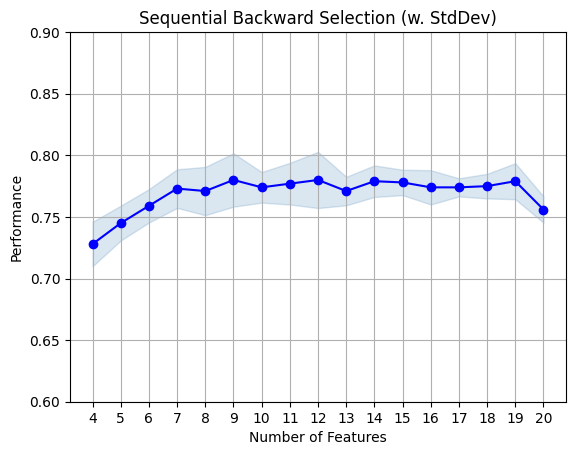

In [9]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')

plt.ylim([0.6, 0.9])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

In [10]:
import plotly.express as px
selected_features_risk = selected_features + ['risk']
df_selected = pd.concat([X_train[selected_features], y_train], axis=1)
corr = df_selected.corr().values

fig = px.imshow(corr,
                labels=dict(color="Correlation"),
                x=selected_features_risk,
                y=selected_features_risk,
                color_continuous_scale= 'BuPu',
               )
fig.update_xaxes(side="bottom")
fig.update_traces(text=np.round(corr,3), texttemplate="%{text}")
fig.update_layout(
    title='Heatmap Correlation',
    title_x=0.5,
    title_y= 0.93,
    width=1000,  # Set the width of the figure (in pixels)
    height=1000,  # Set the height of the figure (in pixels)
    autosize=False  # Disable auto-sizing of the figure
)
fig.show() # Tip: You can hover over all cells to see which pair of features denote that correlation cell.

The correlation heatmap give us insights of relations to the risk target feature. Here are some feature correlations explained:
1. **Credit Amount**: Demanding credit to the bank, the higher, the greater the risk.
2. **Account Status**: Is the feature that is most correlated to risk, which is logic because it denotes the amount of money available in the bank.
3. **Duration in months**: Time to pay off the loan. High correlation as well.
4. **Age**: The younger, the less risk to pay (therefore is negative). Usually does not appear in backward selection.
5. **Telephone** sounds crazy, but in 1980 in Germany, not all citizens were registered, meaning that having a telephone could denote a better financial situation
6. **Guarantors**: The more guarantors, the easier to pay the loan. 

#### Analysis of some features

Duration in Months vs Credit Amount

In [11]:
from constants import RISK_COLOR_MAP

df_plot = df.copy()
df_plot['risk'] = df_plot['risk'].map({2: 'bad', 1: 'good'})
fig = px.scatter(df_plot, x='credit_amount', y='duration_months',color='risk',color_discrete_map= RISK_COLOR_MAP)
fig.update_layout(
    xaxis_title='Credit Amount (DM deutsche mark)',
    yaxis_title='Duration of loan (months)',
    title='Duration vs Credit Amount',
    title_x=0.5,
    title_y= 0.93,
    width=1000,  # Set the width of the figure (in pixels)
    height=500,  # Set the height of the figure (in pixels)
    autosize=False  # Disable auto-sizing of the figure
)
fig.show()

We can observe that the zone of 10 months and to 4k DM the majority candidates are good (low risk) becaue are small loans. 
On the other hand, when the loan exceeds 10K and the duration of months is very close, lets say 30 months, there is a high risk to have a bad candidate, this is a high risk zone.

Histogram Acc Status

In [12]:
df_plot = df.copy()
df_plot['risk'] = df_plot['risk'].map({2: 'bad', 1: 'good'})
df_plot['acc_status'] = df_plot['acc_status'].map({'A11': '< 0 DM', 'A12': '0 <= ... < 200 DM', 'A13': '... >= 200 DM', 'A14': 'No account'})
fig = px.histogram(df_plot, x="acc_status",color='risk', barmode='group',  text_auto=True, height=400, color_discrete_map= RISK_COLOR_MAP)
fig.update_layout(
    xaxis={'categoryorder':'array', 'categoryarray':['< 0 DM','0 <= ... < 200 DM','... >= 200 DM','No account']},
    xaxis_title='Acc Status',
    yaxis_title='Counts',
    title='Risk Histogram for # of candidates wrt Acc Status',
    title_x=0.5,
    title_y= 0.93,
    bargap=0.15,
    width=1000,  # Set the width of the figure (in pixels)
    height=500,  # Set the height of the figure (in pixels)
    autosize=False  # Disable auto-sizing of the figure
) 
fig.show()
ratio_a11=len(df_plot[(df_plot['acc_status'] ==  '< 0 DM') & (df_plot['risk'] ==  'good')])/(len(df_plot[(df_plot['acc_status'] ==  '< 0 DM') & (df_plot['risk'] ==  'good')])+len(df_plot[(df_plot['acc_status'] ==  '< 0 DM') & (df_plot['risk'] ==  'bad')]))
ratio_a12=len(df_plot[(df_plot['acc_status'] ==  '0 <= ... < 200 DM') & (df_plot['risk'] ==  'good')])/(len(df_plot[(df_plot['acc_status'] ==  '0 <= ... < 200 DM') & (df_plot['risk'] ==  'good')])+len(df_plot[(df_plot['acc_status'] ==   '0 <= ... < 200 DM') & (df_plot['risk'] ==  'bad')]))
ratio_a13=len(df_plot[(df_plot['acc_status'] ==  '... >= 200 DM') & (df_plot['risk'] ==  'good')])/(len(df_plot[(df_plot['acc_status'] ==  '... >= 200 DM') & (df_plot['risk'] ==  'good')])+len(df_plot[(df_plot['acc_status'] ==   '... >= 200 DM') & (df_plot['risk'] ==  'bad')]))
ratio_a14=len(df_plot[(df_plot['acc_status'] ==  'No account') & (df_plot['risk'] ==  'good')])/(len(df_plot[(df_plot['acc_status'] ==  'No account') & (df_plot['risk'] ==  'good')])+len(df_plot[(df_plot['acc_status'] ==  'No account') & (df_plot['risk'] ==  'bad')]))

print('Good Risk Ratio for A11 (< 0 DM) ------------> {}'.format(round(ratio_a11,2))) 
print('Good Risk Ratio for A11 (0 <= ... < 200 DM) -> {}'.format(round(ratio_a12,2)))
print('Good Risk Ratio for A11 (... >= 200 DM) -----> {}'.format(round(ratio_a13,2)))
print('Good Risk Ratio for A11 (No account) --------> {}'.format(round(ratio_a14,2)))

Good Risk Ratio for A11 (< 0 DM) ------------> 0.51
Good Risk Ratio for A11 (0 <= ... < 200 DM) -> 0.61
Good Risk Ratio for A11 (... >= 200 DM) -----> 0.78
Good Risk Ratio for A11 (No account) --------> 0.88


- **'<0 DM'**, has the worst ratio, almost half of them have risk. It is logic, knowing that has an account and less than 0 DM. Have debts. 
We have to pay special attention for this group.
- **'0 <= ... < 200 DM'**, clients with some savings in the account. A 61% of good risk. Banks have to take them into account and analyze them in detail.
- **'... >= 200 DM'** has the 2nd greatest good risk ratio of all 4 groups, meaning that those few of them (63) a 78% are good candidates.

- **'No account'** denotes clients that are not registered in that bank. This could mean a low exposure to debts or limited credit histroy, but they normally pay off the loan with a 88% of ratio.


### Training
Let's begin to train a RandomForest, which is one of the best algorithms based on ensemble methods (bagging) there are

#### Random Forest

In [13]:
from utils import train_gridsearch, get_validation_metrics, plot_confusion_matrix, plot_pr_curve

rf = RandomForestClassifier(random_state=SEED) # Fixed seed

params_grid = {'n_estimators': [100,300,500],
               'bootstrap': [True, False],
               'min_samples_leaf':[1,2,3],
              'max_depth':[3,5,10]}

rf_best_model = train_gridsearch(rf, params_grid, X_train[selected_features], y_train)

In [ ]:
get_validation_metrics(rf_best_model)

Validation Results
Precision: 0.687 ± 0.0778
Recall: 0.463 ± 0.0386
Accuracy: 0.773 ± 0.0258
F1: 0.551 ± 0.0396
Balance Accuracy: 0.685 ± 0.0247
ROC AUAC: 0.685 ± 0.0247


In [ ]:
from sklearn.metrics import accuracy_score, recall_score

y_pred = rf_best_model.predict(X_train[selected_features])
print('Accuracy',accuracy_score(y_train, y_pred))
print('Recall',round(recall_score(y_train, y_pred),2)) # The best training metric obtained, there is no better.

Accuracy 0.95
Recall 0.86


In [ ]:
# from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_train, y_pred)

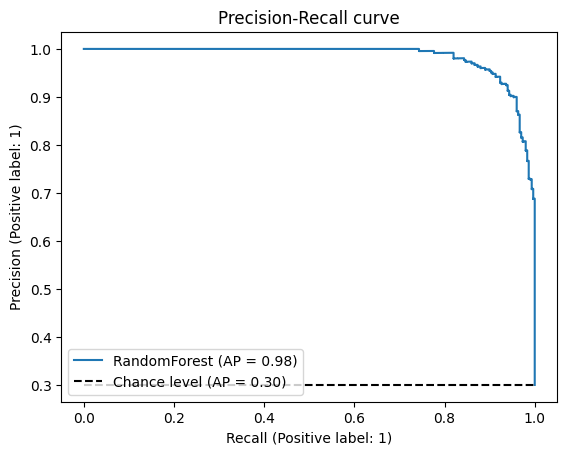

In [ ]:
plot_pr_curve(rf_best_model, X_train[selected_features], y_train, "RandomForest")

Observing the PR curve, we can see that the area under the curve is almost 1, which is a perfect metric of the fitted data from training. The chance level, a random model will lead to an area of 0.3. So, we can say, that the model is well trained but maybe overfitted. Important to consider validation metrics in order to assure the model is not overfited.

In [ ]:
rf_best_model.refit

'recall'

In [ ]:
df_selected = pd.concat([X_train[selected_features], y_train], axis=1)
df_only_good = df_selected[df_selected['risk']==0]
df_only_bad = df_selected[df_selected['risk']==1]

In [ ]:
# Accuracy for good candidates.
y_pred_good = rf_best_model.predict(df_only_good[selected_features])
print(accuracy_score(df_only_good['risk'].values, y_pred_good))

# Accuracy for bad candidates (Recall). The one we have trained for.
y_pred_bad = rf_best_model.predict(df_only_bad[selected_features])
print(round(accuracy_score(df_only_bad['risk'].values, y_pred_bad),2))

0.99
0.86


We have refit the model considering **recall**, because the most severe case is when a bad candidate is given the loan. In order to avoid that, recall has been the metric to be focused on.

Let's try out one of the best bagging methods to train a classifier:

#### XGBOOST

In [ ]:
import xgboost as xgb
from constants import SEED

xgb_m = xgb.XGBClassifier(seed=SEED)

params_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'min_child_weight': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.05],
}

xgb_best_model = train_gridsearch(xgb_m, params_grid, X_train[selected_features], y_train)

Best hyperparameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 0.8}

Best estimator found: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Training Recall: 0.7167



In [ ]:
get_validation_metrics(xgb_best_model)

Validation Results
Precision: 0.652 ± 0.0387
Recall: 0.523 ± 0.0374
Accuracy: 0.773 ± 0.0186
F1: 0.58 ± 0.036
Balance Accuracy: 0.702 ± 0.0231
ROC AUAC: 0.702 ± 0.0231


In [ ]:
from sklearn.metrics import accuracy_score, recall_score

y_pred = xgb_best_model.predict(X_train[selected_features])
print('Accuracy',accuracy_score(y_train, y_pred))
print('Recall',round(recall_score(y_train, y_pred),2)) # The best training metric obtained, there is no better.

Accuracy 0.885
Recall 0.72


In [ ]:
# from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_train, y_pred)

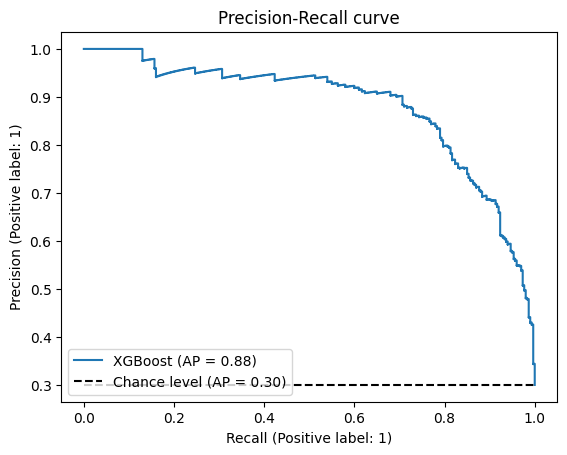

In [ ]:
plot_pr_curve(xgb_best_model, X_train[selected_features], y_train, "XGBoost")

In [ ]:
# Accuracy for good candidates.
y_pred_good = xgb_best_model.predict(df_only_good[selected_features])
print(round(accuracy_score(df_only_good['risk'].values, y_pred_good),3))

# Accuracy for bad candidates. The one we have trained for.
y_pred_bad = xgb_best_model.predict(df_only_bad[selected_features])
print(round(accuracy_score(df_only_bad['risk'].values, y_pred_bad),3))

0.957
0.717


#### Comparison

After analyzing XGBoost and RandomForest, the best results in training are provided by **RandomForest** and in evaluation by  **XGBoost**. Despite the great difference in training, we select XGboost as best model due to the fact, that in evaluation is performing better, specifically, recall metric. In other words, XGBoost is generalizing better and reducing these undesired False Negatives, which are bad clients, being categorized as good, so high risk for banks to lend money.

In [ ]:
import pandas as pd
training = pd.DataFrame({'Model' : ['Random Forest', 'XGBoost'],
                                 'Mode' : ['training', 'training'],
                                 'Precision':[0.99,0.968],
                                 'Recall': [0.8567,0.783],
                                 'Accuracy':[0.95, 0.913],
                                 'AUC PR': [0.98, 0.94],})
validation = pd.DataFrame({'Model' :['Random Forest', 'XGBoost'],
                                 'Mode' : ['validation', 'validation'],
                                 'Precision': [0.687 ,0.64],
                                 'Recall': [0.463,0.51],
                                 'Accuracy':[0.773, 0.7673],
                                 'F1':[0.551, 0.56],
                                 'Balance Accuracy':[0.685 ,0.694],
                                 'ROC AUC': [0.685, 0.6940],})
training

Model      Mode  Precision  Recall  Accuracy  AUC PR
0  Random Forest  training      0.990  0.8567     0.950    0.98
1        XGBoost  training      0.968  0.7830     0.913    0.94

In [ ]:
validation

Model        Mode  Precision  Recall  Accuracy     F1  \
0  Random Forest  validation      0.687   0.463    0.7730  0.551   
1        XGBoost  validation      0.640   0.510    0.7673  0.560   

   Balance Accuracy  ROC AUC  
0             0.685    0.685  
1             0.694    0.694

Feature Importance of Random Forest

In [ ]:
import plotly.graph_objects as go

xgb_m = xgb_best_model.best_estimator_
importances = xgb_m.feature_importances_ # Probability distribution
# std = np.std([random_forest.feature_importances_ for tree in random_forest.estimators_], axis=0)
importances
data = {
    "Importances":importances,
    "Features":selected_features,
}
fig = px.bar(data, y='Importances', x='Features', text_auto='.2f',
            title="Feature Importance (Probability Distribution)")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(
    barmode='group',
    title='Feature Importance (Probability Distribution)',
    title_x=0.5,
    title_y= 0.93,
    width=1000,  # Set the width of the figure (in pixels)
    height=500,  # Set the height of the figure (in pixels)
    autosize=False  # Disable auto-sizing of the figure
)
fig.show()

SHAP VALUES

Being the output: 1, the waterfall graph for 1 sample (impact of each feature in SHAP values) looks like this:


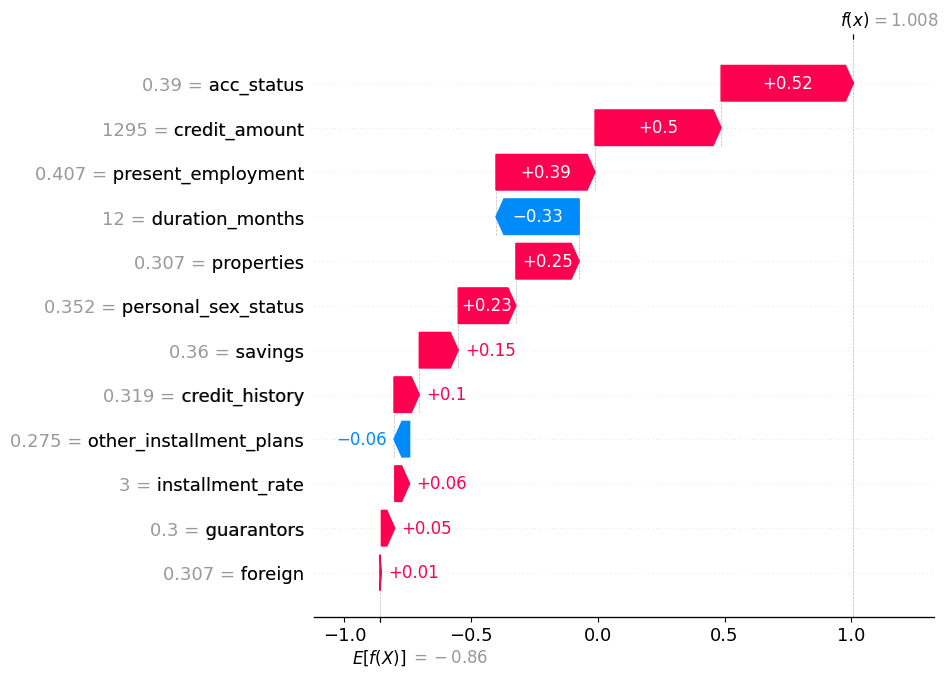

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_m)

# Calculate SHAP values
shap_values = explainer(X_train[selected_features])
print('Being the output: {}, the waterfall graph for 1 sample (impact of each feature in SHAP values) looks like this:'.format(y_train.iloc[10]))
color_positive = (0, 128, 0)  # Custom color for positive contributions (green in RGB format)
color_negative = (128, 0, 128)
shap.plots.waterfall(shap_values[10], max_display=len(selected_features)) # Remember this plot is for 1 sample of the training dataset.

# Summary plot of SHAP values
# shap.summary_plot(shap_values, X_train[selected_features], plot_type="bar")

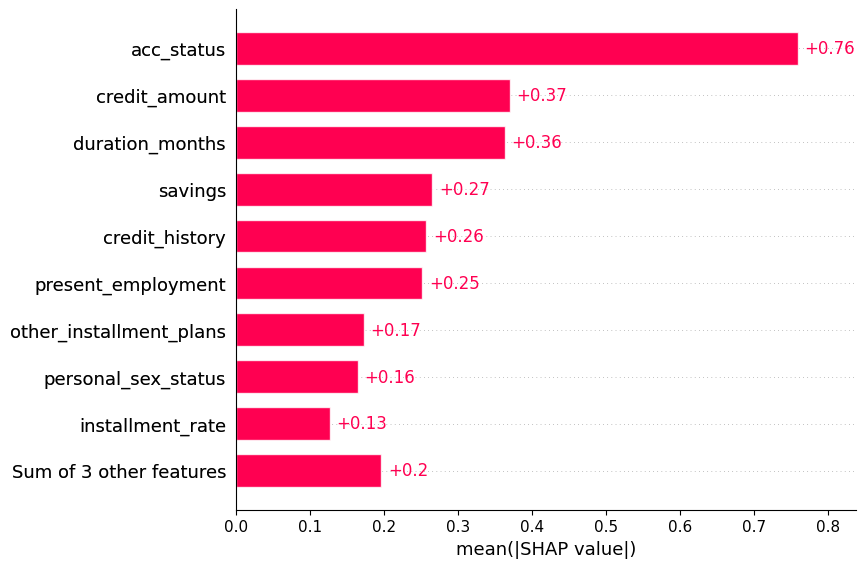

In [ ]:
shap.plots.bar(shap_values)

In the following graph we can see clearly that low amounts of loan correspond to low duration in months. There is tendency upwards in risk (high SHAP values) when duration_months and credit_amount increase, but, there is a zone for middle ~ 3.800 and n_months very diversed, where we have to take special care, because they correspond to low risk (negative SHAP values).

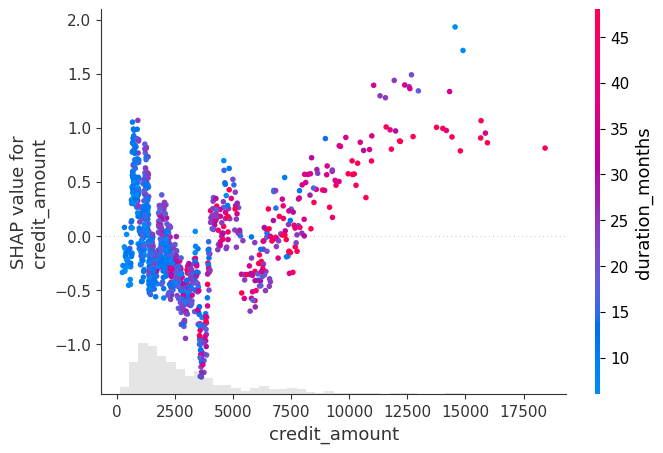

In [ ]:
shap.plots.scatter(shap_values[:, "credit_amount"], color=shap_values) # Automatically finds best second feature to color by.

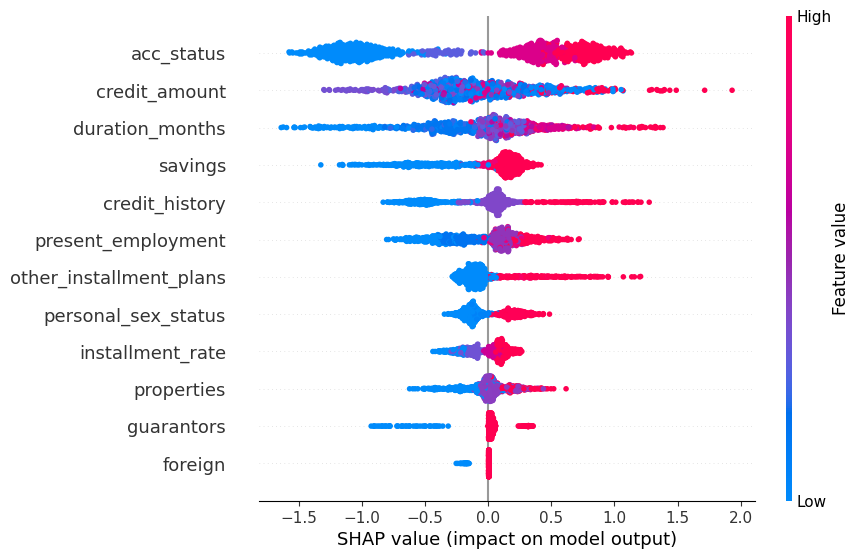

In [ ]:
shap.plots.beeswarm(shap_values,  max_display=len(selected_features))

In [ ]:
df_plot = df.copy()
df_plot['risk'] = df_plot['risk'].map({2: 'bad', 1: 'good'})
cat_order = {'risk': ['Less than 0 DM', 'Between 0 and 200 DM', 'more than 200 DM', 'No account']}
df_plot['acc_status'] = df_plot['acc_status'].map({'A11': 'Less than 0 DM', 'A12': 'Between 0 and 200 DM', 'A13': 'more than 200 DM', 'A14': 'No account'})
df_plot['acc_status'].value_counts()

fig = px.scatter(df_plot, x='credit_amount', y='duration_months',color='risk', facet_col="acc_status",  color_discrete_map=RISK_COLOR_MAP)
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1], font={'size': 10}))
fig.show()

In [ ]:
df_plot

acc_status  duration_months credit_history purpose  \
0          Less than 0 DM                6            A34     A43   
1    Between 0 and 200 DM               48            A32     A43   
2              No account               12            A34     A46   
3          Less than 0 DM               42            A32     A42   
4          Less than 0 DM               24            A33     A40   
..                    ...              ...            ...     ...   
995            No account               12            A32     A42   
996        Less than 0 DM               30            A32     A41   
997            No account               12            A32     A43   
998        Less than 0 DM               45            A32     A43   
999  Between 0 and 200 DM               45            A34     A41   

     credit_amount savings present_employment  installment_rate  \
0             1169     A65                A75                 4   
1             5951     A61                A73                 2   
2             2096     A61                A74                 2   
3             7882     A61                A74                 2   
4             4870     A61                A73                 3   
..             ...     ...                ...               ...   
995           1736     A61                A74                 3   
996           3857     A61                A73                 4   
997            804     A61                A75                 4   
998           1845     A61                A73                 4   
999           4576     A62                A71                 3   

    personal_sex_status guarantors  ...  properties age  \
0                   A93       A101  ...        A121  67   
1                   A92       A101  ...        A121  22   
2                   A93       A101  ...        A121  49   
3                   A93       A103  ...        A122  45   
4                   A93       A101  ...        A124  53   
..                  ...        ...  ...         ...  ..   
995                 A92       A101  ...        A121  31   
996                 A91       A101  ...        A122  40   
997                 A93       A101  ...        A123  38   
998                 A93       A101  ...        A124  23   
999                 A93       A101  ...        A123  27   

     other_installment_plans housing n_credits  job_status liable_support  \
0                       A143    A152         2        A173              1   
1                       A143    A152         1        A173              1   
2                       A143    A152         1        A172              2   
3                       A143    A153         1        A173              2   
4                       A143    A153         2        A173              2   
..                       ...     ...       ...         ...            ...   
995                     A143    A152         1        A172              1   
996                     A143    A152         1        A174              1   
997                     A143    A152         1        A173              1   
998                     A143    A153         1        A173              1   
999                     A143    A152         1        A173              1   

     telephone foreign  risk  
0         A192    A201  good  
1         A191    A201   bad  
2         A191    A201  good  
3         A191    A201  good  
4         A191    A201   bad  
..         ...     ...   ...  
995       A191    A201  good  
996       A192    A201  good  
997       A191    A201  good  
998       A192    A201   bad  
999       A191    A201  good  

[1000 rows x 21 columns]

I picked 4 important features based on feature importance during XGBoost training. It is quite difficult to interpret these 4 features at the same time, therefore I sepparated into 4 plots (acc_status) in order to see the behaviour with the most important features. Of course, there are 8 more features that are affecting to the risk of loan and we have to have it in the radar. But the rest are categorical (now encoded), and makes difficult to interpret them graphically.
Observing this graph and having in mind the previous one, we can say that extremes in group A12 (between 0 and 200 DM) are normally bad candidates. These people are the ones, that get high loans and high duration in months, but in that extrems they fail to pay off the loan. This can be produced due to the fact, that the bank allows the loan with high interests, where these type of clients are prepared to accept because they do not have enough money. Group 'more than 200 DM' are normally good candidates except for short period of time. The same for group 'No account', normally they pay.
It would be interesting to deal with the rest of data, but each group should be analyzed carefully, because at first sight, we cannot say that is trivial to categorize them as bad or good candidate.

#### Saving model

In [ ]:
import pickle

xgb_m = xgb_best_model.best_estimator_
with open('../models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_m, f)

#### Load model + encoder and predict

In [ ]:
model= pickle.load(open('../models/xgb_model.pkl', 'rb'))
y_pred = model.predict(X_train[selected_features].iloc[1:10])
print('True target risk: {}'.format(y_train.iloc[1:10].values))
print('Predicted risk:   {}'.format(y_pred))

True target risk: [1 0 0 1 0 0 0 0 1]
Predicted risk:   [1 0 0 1 0 0 0 0 1]


In [ ]:
type(model)

xgboost.sklearn.XGBClassifier

In [ ]:
import pandas as pd

encoder_path = '../models/target_encoder.json'
with open(encoder_path, 'r') as json_file:
    json_data = json.load(json_file)

In [ ]:
json_data['acc_status']

{'A11': 0.49270072992521335,
 'A12': 0.3903345724893198,
 'A14': 0.116751269035533,
 'A13': 0.22326342694215168,
 'NaN': 0.3}

#### Real Example

##### Encode

In [ ]:
df.iloc[5:6]
row = df.iloc[5:6]
mapping = json_data['acc_status']
# Encode categorical variables
for k,v in json_data.items():
    row.loc[5:6,k] = row[k].map(v)

##### Predict

In [ ]:
# XGBoost does not like categorical columns, must be transformed to numerical.
myrow = row[selected_features].apply(pd.to_numeric)

In [ ]:
y_pred = model.predict(myrow)
y_pred == y_train.iloc[5:6].values

array([ True])

In [ ]:
y_pred = model.predict_proba(myrow)
y_pred

array([[0.7880624 , 0.21193762]], dtype=float32)